## _Order of Accuracy of Padé schemes_

Now let's look at how a five-point, second-order finite difference scheme fares against the corresponding central Pade scheme with the same computational stencil. Consider finding the Laplacian of a smooth function, u, in two dimensions such that:

\begin{equation*} u(x,y) = \sin(2 \pi x) \sin(2 \pi y) \end{equation*}

where: \begin{equation*} 0 \leq x, y \leq 1 \end{equation*}

The Laplacian of *u* can be trivially found  as:

\begin{equation*}\nabla ^2 u = -8 \pi^2 \sin(2 \pi x) \sin(2 \pi y) \end{equation*}

Over the given domain, contour plots of u and its Laplacian look like:

![Contours of u and its Laplacian](./Images/Exact_U_nablaU.png)
_Figure 1. Contour plots of (left) u and (right) its Laplacian. _

### _Discretization_: 

Both discretization schemes employed herein employ a five-point stencil involving the point at which the solution is to be obtained and its four neighbors. The stencial is illustrated in Figure 2. The point highlighted in red is the one where the solution is computed. The green points are the nighbors over which the solution is diffused. Thus, all points enclosed in the blue boxes make the computational stencil.

![Diffusion Stencil](./Images/2D_diffusion_stencil.png)
_Figure 2. Computational stencil in two dimensions including the current solution point and its four neighbors_

### _Finite Difference Scheme_:

In the traditional finite-difference scheme, a second-order, centered approximation (CDS) to the second derivative of f, with respect to x, can be written as:

\begin{equation*}
\left({f_{xx}}\right)_{i,j}= \frac{f_{i+1, j} - 2f_{i,j} + f_{i-1,j}}{\Delta x^2}
\end{equation*}

### _Padé Scheme_:

The corresponding Padé scheme system is formulated as:

\begin{equation*}
\frac{1}{10}\left({f_{xx}}\right)_{i-1,j} + \left({f_{xx}}\right)_{i,j} + \frac{1}{10}\left({f_{xx}}\right)_{i+1,j} = \frac{12}{10}\left(\frac{f_{i+1, j} - 2f_{i,j} + f_{i-1,j}}{\Delta x^2}\right)
\end{equation*}


Now let's look at a sample code that implements the two discretization methods and compare their orders of accuracy. 

In [20]:
# Code for finite differencing. 

%matplotlib notebook
from numpy import *
from matplotlib import *
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [21]:
#Finite difference code for second derivative
def d2u_FD(u, dh):
    ng = size(u[1,:]);
    
    dder = zeros_like(u);
    
    for i in range (1, ng-1):
        for j in range (1, ng-1):
            dder[i][j] = (u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1] - 4*u[i,j])/(dh*dh);
    
    return dder;

In [22]:
# Compact Finite difference code for second derivative
def d2u_CFD(u,dh):
    ng = size(u[1,:]);
    
    dder = zeros_like(u);
    ddx  = zeros_like(u);
    ddy  = zeros_like(u);
    
    A = zeros((ng,ng)); bx = zeros(ng); by = zeros(ng);

    #Evaluate d2u/dx2
    for i in range (1, ng-1):
        A[0,0] = 1; A[-1,-1] = 1;
        for j in range (1, ng-1):
            A[j][j-1:j+2] = [0.1, 1.0, 0.1];
            bx[j] = 1.2/(dh*dh)*(u[i-1,j]-2*u[i,j]+u[i+1,j]);
        Ainv = linalg.inv(A);
        ddx[i,:] = Ainv.dot(bx);

    #print(A);

    #Evaluate d2u/dy2
    for j in range (1, ng-1):
        A[0,0] = 1; A[-1,-1] = 1;
        for i in range (1, ng-1):
            A[i][i-1:i+2] = [0.1, 1.0, 0.1];
            by[i] = 1.2/(dh*dh)*(u[i-1,j]-2*u[i,j]+u[i+1,j]);
        Ainv = linalg.inv(A);
        ddy[:,j] = Ainv.dot(by);

    #print(d2ux);
    dder = ddx + ddy;
    
    return dder;

In [23]:
# Main part of code:
ng = 6; nref = 4
Xmin = 0.0; Xmax = 1.0;
Ymin = 0.0; Ymax = 1.0;

dx     = zeros(nref);
ErrFD  = zeros(nref);
ErrCFD = zeros(nref);

for ref in range (nref):
    
    dh = (Xmax-Xmin)/(ng-1);
    dx[ref] = dh

    x = arange(Xmin, Xmax+dh, dh);
    y = arange(Ymin, Ymax+dh, dh);

    u = zeros((ng,ng));
    dduFD  = zeros_like(u);
    dduCFD = zeros_like(u);
    d2uex = zeros_like(u);

    #Define u
    for i in range (ng):
        for j in range (ng):
            u[i,j] = sin(2*pi*x[i])*sin(2*pi*y[j]);

    dduFD = d2u_FD(u,dh);
    dduCFD = d2u_CFD(u,dh);
    
    #Error analysis:
    for i in range (1,ng-1):
        for j in range (1, ng-1):
            d2uex[i,j] = -8*pi**2*sin(2*pi*x[i])*sin(2*pi*y[j]);
            ErrFD[ref] = ErrFD[ref] + (d2uex[i,j]-dduFD[i,j])**2;
            ErrCFD[ref] = ErrCFD[ref] + (d2uex[i,j]-dduCFD[i,j])**2;

    ErrFD[ref]  = (ErrFD[ref]/(ng-1)**2)**0.5;
    ErrCFD[ref] = (ErrCFD[ref]/(ng-1)**2)**0.5;
    
    #print('')
    #print('Error norms for ng:', ng)
    #print('Finite difference:', ErrFD[ref]);
    #print('Compact Finite difference:', ErrCFD[ref]);
    
    ng = (ng-1)*2 + 1;

<IPython.core.display.Javascript object>


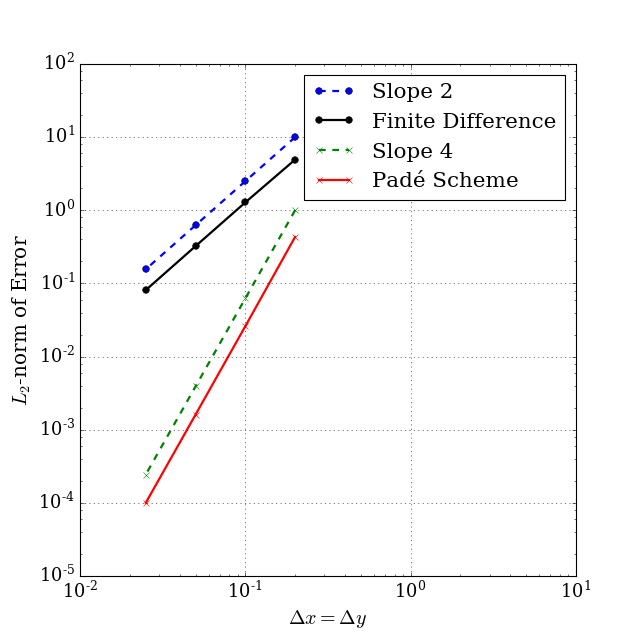

In [32]:
#Define two lines for indicating slopes
slope2 = [10, 2.5, 0.625, 0.15625];
slope4 = [1, 0.0625, 0.00390625, 0.00024414062];

# plot using the matplotlib function loglog()
pyplot.figure(figsize=(8,8))
pyplot.grid(True)
pyplot.xlabel(r'$\Delta x = \Delta y$', fontsize=18)
pyplot.ylabel(r'$L_2$-norm of Error', fontsize=18)
pyplot.loglog(dx[:], slope2, color='b', ls='--', lw=2, marker='o', label = 'Slope 2');
pyplot.loglog(dx[:], ErrFD[:], color='k', ls='-', lw=2, marker='o', label = 'Finite Difference');
pyplot.loglog(dx[:], slope4, color='g', ls='--', lw=2, marker='x', label = 'Slope 4');
pyplot.loglog(dx[:], ErrCFD[:], color='r', ls='-', lw=2, marker='x', label = 'Padé Scheme');
pyplot.xlim(1e-2,10);
pyplot.ylim(1e-5,100);
pyplot.legend();

From the above graph we see that the errors using the Padé scheme scaled with the fourth power of grid size, as spoosed to the finite difference scheme where the errors scaled with the second power of size, thus demonstrating their orders of accuracy. 

## _Applications to differential equations_

### _Hyperbolic equations_

Let us now compare how a second-order, upwind Padé scheme fares against the corresponding first order finite-difference scheme for a one-dimensional hyperbolic eqaution. Consider the unsteady wave equation

\begin{equation*}
\frac{\partial T}{\partial t } + c\frac{\partial T}{\partial x } = 0
\end{equation*}

# ***Show stencil***

As seen in module 2 lesson 1 [CITATION], a centered difference approximation of the spatial derivatives failed to capture the dynamics of wave propagation and a backward difference scheme was employed. The spatial derivative of a smooth function, f, with respect to x can be expressed as:

\begin{equation*}
\left({f_{x}}\right)_{i,j}  = \frac{f_{i, j} - f_{i-1,j}}{\Delta x}
\end{equation*}

Choosing the same computational stencil, 

In [35]:
from IPython.core.display import HTML
css_file = './style.css'
HTML(open(css_file, "r").read())